### Best Models Results


In [78]:
import time
import math
notebook_start = time.time()

#### Init Libraries

In [79]:
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import os

In [80]:
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.regularizers import l1, l2
#from keras.layers import Dropout, Flatten, BatchNormalization
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks
from keras import utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf

#### Load Dataset and split into Features and Label

In [81]:
#load data
df=pd.read_csv("breast-cancer-wisconsin-data/data.csv")
#drop irelevent columns for the classification
df = df.drop(columns=['Unnamed: 32', 'id'])
# rearange the data for X - featuers and Y leabels 
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

#### Encode Labels

In [82]:
le = LabelEncoder()
y = le.fit_transform(y)

#### The mapping of the labels

In [83]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'B': 0, 'M': 1}


#### Splitting the data into Train, Test and Valid datasets

In [84]:
#split the data
from sklearn.model_selection import train_test_split
XData_train_val, XData_test, ydata_train_val, ydata_test = train_test_split(X, y, test_size=0.2, random_state=0)
XData_train, XData_val, ydata_train, ydata_val = train_test_split(XData_train_val, ydata_train_val, test_size=0.2, random_state=0)

#### Scale the data

In [85]:
scaler = RobustScaler()
X_train = scaler.fit_transform(XData_train)
X_test = scaler.transform(XData_test)
X_val = scaler.transform(XData_val)

X_train_val = XData_train_val.values

y_train = ydata_train
y_test = ydata_test
y_val = ydata_val

y_train_val = ydata_train_val

#### Handling the imbalance between the classes

In [86]:
#handling imbalance data 
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
#the class weight is done only on the train data to impact the learning process and to evaluete beter the model proformence
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.774468085106383, 1: 1.4108527131782946}

##### Function Helpers

In [87]:
def model_result(model, X, y, dataset_name):
    print('================================================================================')
    print(f'Evaluation Report for Model: {model.name} on {dataset_name}')

    # accuracy
    result = model.evaluate(X, y, verbose=0)        
    print(f'Loss Value: {result[0]:.3f}, Accuracy: {result[1]*100:.3f}%')

    # confusion matrix
    y_prob = model.predict(X, verbose=0)
    y_pred = np.round(y_prob).astype(int)    
    cm = confusion_matrix(y, y_pred)    
    #sns.heatmap(cm,annot=True)
    cm_disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    cm_disp.plot()
    plt.title(f'{model.name} Confusion Matrix on {dataset_name} Dataset')
    plt.show()

    # classification report
    report = classification_report(y, y_pred, target_names=le.classes_)
    print(report)

    print('Model Summary:')
    print(model.summary())
    print('================================================================================')

In [97]:
def model_history(history, param=None):
    plt.figure(figsize=(15,6))

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    if param is None:
        plt.title('Train and Validation Loss')
    else:
        plt.title(f'Train and Validation Loss on {param}')

    plt.plot(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], 'r*', label='Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_loss'][val_loss_min_pos]:.3f})', va='bottom')
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], 'r*', label='Validation Accuracy @ Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_accuracy'][val_loss_min_pos]:.3f})', va='bottom')

    if param is None:
        plt.title('Train and Validation Accuracy')
    else:
        plt.title(f'Train and Validation Accuracy on {param}')
        
    plt.legend()

    plt.show()    

In [89]:
def proc_history(history):

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    train_acc = history.history['accuracy'][val_loss_min_pos]
    train_loss = history.history['loss'][val_loss_min_pos]

    val_acc = history.history['val_accuracy'][val_loss_min_pos]
    val_loss = history.history['val_loss'][val_loss_min_pos]    

    val_recall = history.history['val_recall'][val_loss_min_pos]

    return {'Train Accuracy': train_acc, 'Train Loss': train_loss, 'Validation Accuracy': val_acc, 'Validation Loss': val_loss, 'Validation Recall': val_recall}

In [90]:
def model_fit(model, optimizer=optimizers.RMSprop, learning_rate=0.001, epochNum=1000, batchSize=32, en_reduce_lr=False, en_early_stopping=True, pca=False, verbose="auto", Dataset=None):      
    
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=0)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=0)
    checkpoint_filepath = f'model_checkpoints/{model.name}_checkpoint.model.keras'
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0)
    
    callbacks_list = [model_checkpoint_callback]

    if en_reduce_lr:
        callbacks_list.append(reduce_lr)

    if en_early_stopping:
        callbacks_list.append(early_stopping)

    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', metrics.Recall(name='recall')])
    if Dataset is None:
        history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epochNum, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)
    else:
        history = model.fit(Dataset['X_train'], Dataset['y_train'], batch_size=batchSize, epochs=epochNum, validation_data=(Dataset['X_val'], Dataset['y_val']), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)

    model = models.load_model(checkpoint_filepath)

    return history, model

In [91]:
def model_kfold(xtrain, ytrain, model_base, optimizer=optimizers.RMSprop,learning_rate=0.001, epochNum=1000, batchSize=32, en_reduce_lr=False, en_early_stopping=True, verbose="auto"):
    model = models.clone_model(model_base)
    fold_k = StratifiedKFold(n_splits = 5).split(xtrain, ytrain)
    
    result_df = pd.DataFrame(columns=['k', 'Train Accuracy', 'Train Loss' , 'Validation Accuracy', 'Validation Loss',  'Validation Recall'])
    for k , (train, valid) in enumerate(fold_k):

        scaler = RobustScaler()

        X_train = scaler.fit_transform(xtrain[train])
        X_val = scaler.transform(xtrain[valid])
        
        dataset = {'X_train': X_train, 'y_train': ytrain[train], 'X_val': X_val, 'y_val': ytrain[valid]}
        model.set_weights(model_base.get_weights())

        

        history, model = model_fit(model, optimizer=optimizer, learning_rate=learning_rate, epochNum=epochNum, batchSize=batchSize, en_reduce_lr=en_reduce_lr, en_early_stopping=en_early_stopping, Dataset=dataset, verbose=verbose)    
        
        proc_data = proc_history(history)

        new_row = {'k': k, **proc_data}

        result_df.loc[len(result_df)] = new_row

    return result_df

### Best Models

In [98]:
BEST_MODELS = {}
BEST_MODELS_HISTORY = {}

BEST_OPTIMIZER = optimizers.SGD
BEST_LEARNING_RATE = 0.001
BEST_BATCH_SIZE = 2

#### SLP Model

In [99]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'SLP')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

BEST_MODELS['SLP'] = BEST_MODEL

#### MLP 30x30x1 

In [100]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'MLP_30x30x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

BEST_MODELS['MLP_30x30x1'] = BEST_MODEL

#### MLP 30x30x10x1 and at Second Layer: Dropout 0.1 & Activation Function Silu

In [101]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'MLP_30x10x10-D1-silu-x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(10, activation='relu'))
BEST_MODEL.add(layers.Dense(10, activation='silu'))
BEST_MODEL.add(layers.Dropout(0.1))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

BEST_MODELS['MLP_30x10x10-D1-silu-x1'] = BEST_MODEL

#### Fit Best Models

----------------------------------------------------------------------------------------------------
Model Name = SLP
Validation Accuracy Mean: 0.06189839020371437, Validation Accuracy STD: 0.02392254905859534
Validation Loss Mean: 0.06189839020371437, Validation Loss STD: 0.02392254905859534
   k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.980769    0.067401             0.978022         0.053599   
1  1        0.980769    0.058059             0.978022         0.058055   
2  2        0.986264    0.048997             0.956044         0.103804   
3  3        0.975275    0.062322             0.989011         0.048816   
4  4        0.975275    0.068198             1.000000         0.045217   

   Validation Recall  
0           1.000000  
1           0.969697  
2           0.909091  
3           1.000000  
4           1.000000  


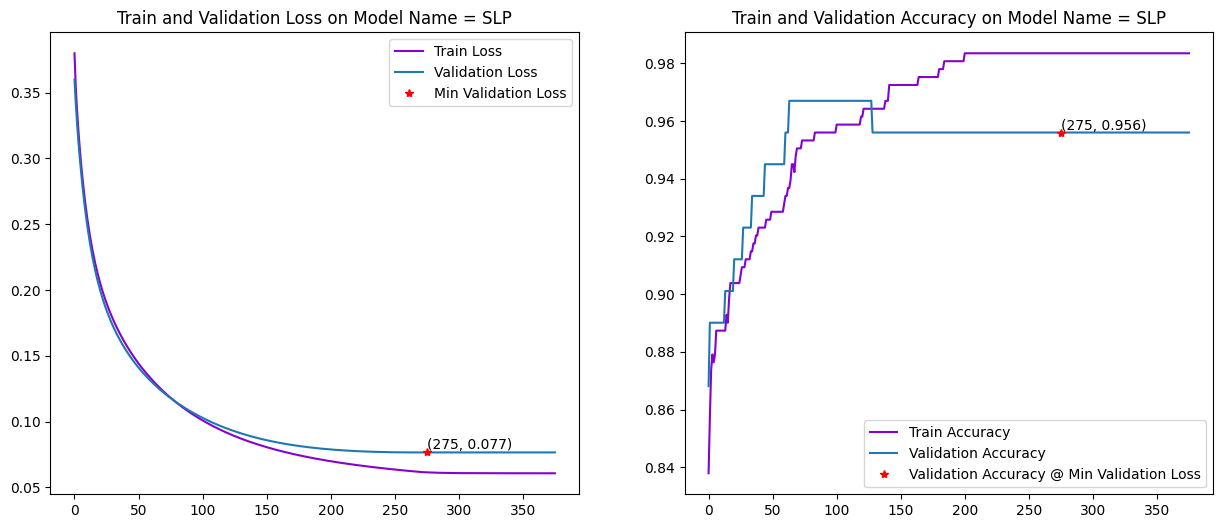

----------------------------------------------------------------------------------------------------
Model Name = MLP_30x30x1
Validation Accuracy Mean: 0.07219427302479745, Validation Accuracy STD: 0.029286515296389735
Validation Loss Mean: 0.07219427302479745, Validation Loss STD: 0.029286515296389735
   k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.980769    0.077590             0.989011         0.059190   
1  1        0.983516    0.068860             0.978022         0.062123   
2  2        0.989011    0.058609             0.956044         0.124124   
3  3        0.978022    0.079873             1.000000         0.052908   
4  4        0.980769    0.077509             0.989011         0.062626   

   Validation Recall  
0           1.000000  
1           0.969697  
2           0.909091  
3           1.000000  
4           1.000000  


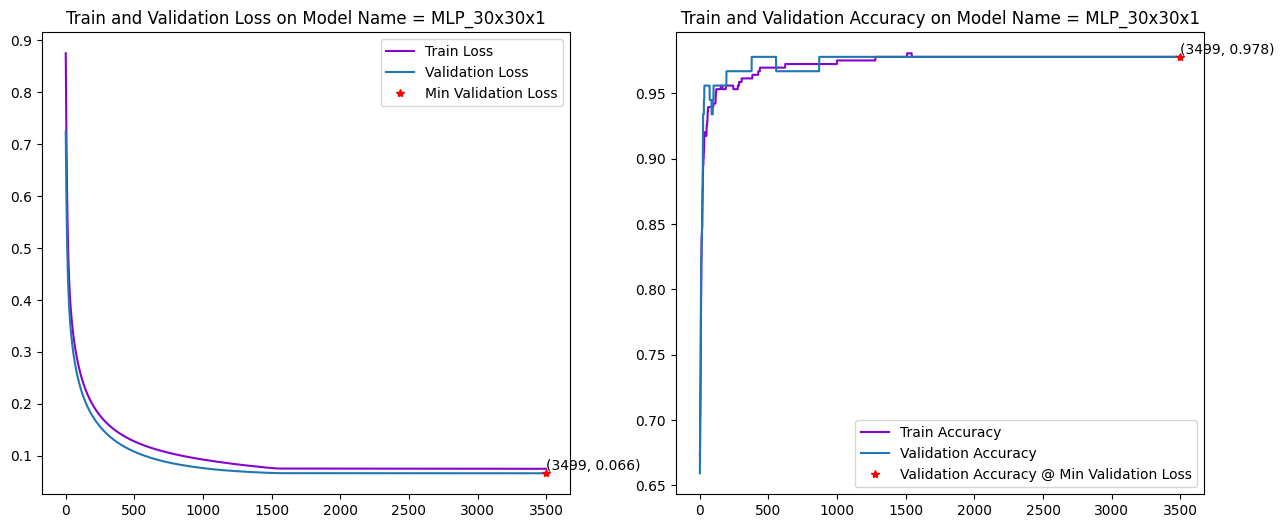

----------------------------------------------------------------------------------------------------
Model Name = MLP_30x10x10-D1-silu-x1
Validation Accuracy Mean: 0.05927567221224308, Validation Accuracy STD: 0.03295741476041058
Validation Loss Mean: 0.05927567221224308, Validation Loss STD: 0.03295741476041058
   k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.978022    0.077846             0.978022         0.053299   
1  1        0.980769    0.075503             0.978022         0.056483   
2  2        0.989011    0.054096             0.956044         0.115224   
3  3        0.969780    0.078470             0.989011         0.041077   
4  4        0.980769    0.107281             0.978022         0.030295   

   Validation Recall  
0           1.000000  
1           0.969697  
2           0.909091  
3           1.000000  
4           0.969697  


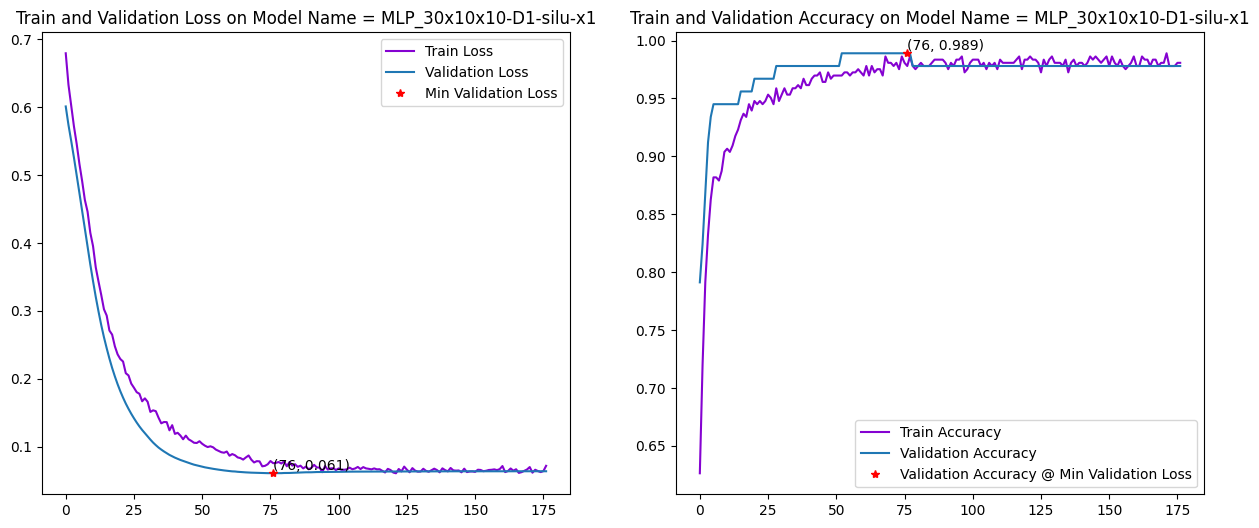

In [102]:
nn_best_models_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

for model_name, model in BEST_MODELS.items():

    print('----------------------------------------------------------------------------------------------------')
    print(f'Model Name = {model_name}')
    
    if model_name == 'SLP':
        history, model = model_fit(model, epochNum=2500, batchSize=32, en_early_stopping=True, en_reduce_lr=True, verbose=0)
        res_df = model_kfold(X_train_val, y_train_val, model, epochNum=2500, batchSize=32, en_early_stopping=True, en_reduce_lr=True, verbose=0)
    elif model_name == 'MLP_30x30x1':
        history, model = model_fit(model, epochNum=3500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=32, en_early_stopping=True, en_reduce_lr=True, verbose=0)
        res_df = model_kfold(X_train_val, y_train_val, model, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, epochNum=3500, batchSize=32, en_early_stopping=True, en_reduce_lr=True, verbose=0)        
    else:
        history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
        res_df = model_kfold(X_train_val, y_train_val, model, epochNum=2500, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)

    BEST_MODELS_HISTORY[model_name] = history
    proc_data = proc_history(history)

    new_row = {'Model Name': model.name, **proc_data}
    nn_best_models_df.loc[len(nn_best_models_df)] = new_row

    
    print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
    print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
    print(res_df)

    model_history(history, f'Model Name = {model.name}')

In [20]:
nn_best_models_df

,Model Name,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,SLP,0.983516,0.061391,0.956044,0.076515,0.972222
1,MLP_30x30x1,0.978022,0.074875,0.978022,0.066211,0.972222
2,MLP_30x10x10-D1-silu-x1,0.978022,0.075673,0.989011,0.060973,0.972222


##### Validation Accuracy Learning Curve of all all Best Models

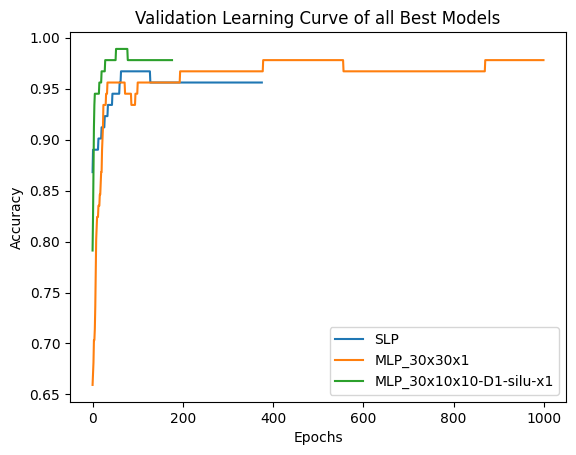

In [47]:
for model_name, history in BEST_MODELS_HISTORY.items():
    plt.plot(history.history['val_accuracy'][:1000], label=model_name)
plt.legend()
plt.title('Validation Accuracy Learning Curve of all Best Models')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

##### Validation Loss Learning Curve of all all Best Models

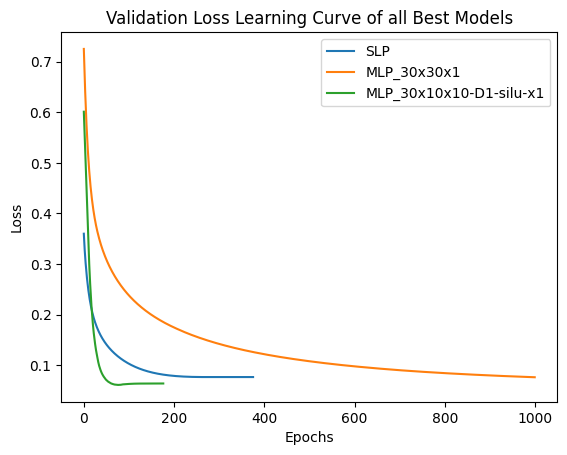

In [48]:
for model_name, history in BEST_MODELS_HISTORY.items():
    plt.plot(history.history['val_loss'][:1000], label=model_name)
plt.legend()
plt.title('Validation Loss Learning Curve of all Best Models')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

##### Train and Validation Accuracy of all Best Models

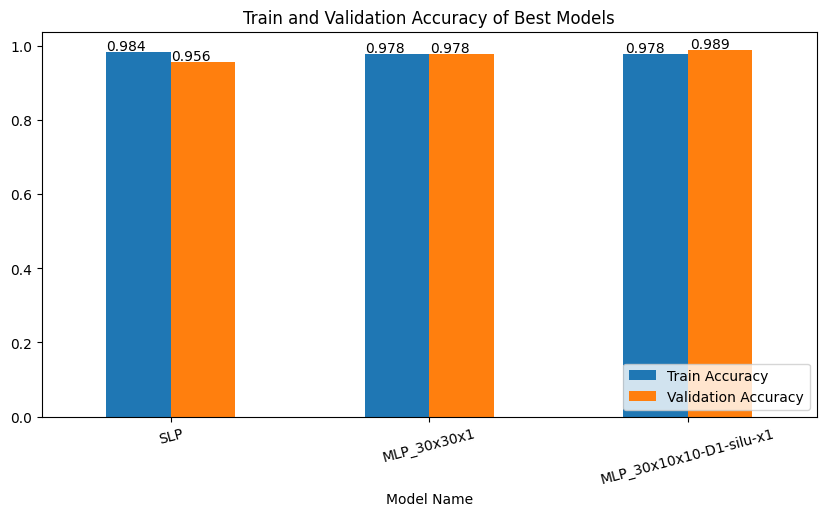

In [21]:
axes = nn_best_models_df.plot.bar(x='Model Name', y=['Train Accuracy', 'Validation Accuracy'], rot=15, figsize=(10, 5))
axes.legend(loc='lower right')

for p in axes.patches:
    axes.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

_ = axes.set_title('Train and Validation Accuracy of Best Models')

##### Train and Validation Loss of all Best Models

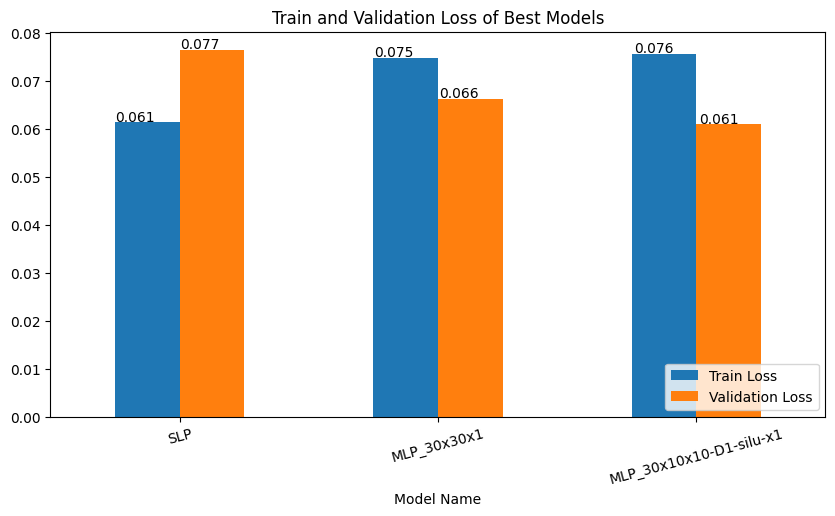

In [22]:
axes = nn_best_models_df.plot.bar(x='Model Name', y=['Train Loss', 'Validation Loss'], rot=15, figsize=(10, 5))
axes.legend(loc='lower right')

for p in axes.patches:
    axes.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

_ = axes.set_title('Train and Validation Loss of Best Models')

### Train+Validation Evaluation

#### Train Evaluation on Best Models

Evaluation Report for Model: SLP on Train
Loss Value: 0.063, Accuracy: 98.352%


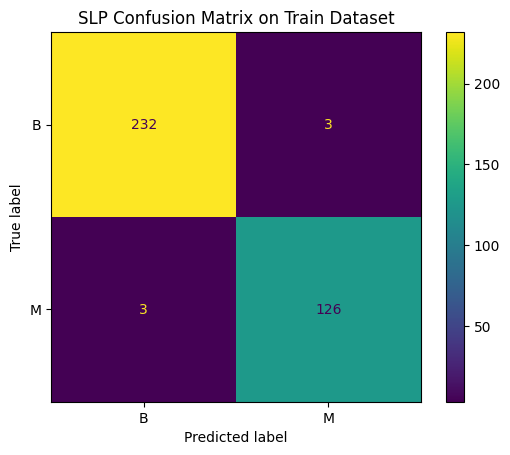

              precision    recall  f1-score   support

           B       0.99      0.99      0.99       235
           M       0.98      0.98      0.98       129

    accuracy                           0.98       364
   macro avg       0.98      0.98      0.98       364
weighted avg       0.98      0.98      0.98       364

Model Summary:


Model: "SLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64 (260.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33 (136.00 B)

None
Evaluation Report for Model: MLP_30x30x1 on Train
Loss Value: 0.076, Accuracy: 97.802%


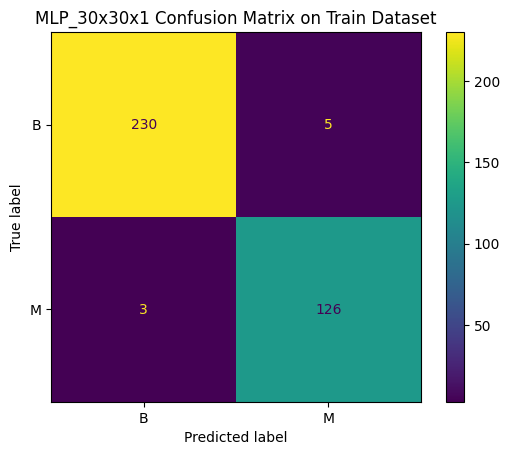

              precision    recall  f1-score   support

           B       0.99      0.98      0.98       235
           M       0.96      0.98      0.97       129

    accuracy                           0.98       364
   macro avg       0.97      0.98      0.98       364
weighted avg       0.98      0.98      0.98       364

Model Summary:


Model: "MLP_30x30x1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963 (3.77 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Evaluation Report for Model: MLP_30x10x10-D1-silu-x1 on Train
Loss Value: 0.070, Accuracy: 98.352%


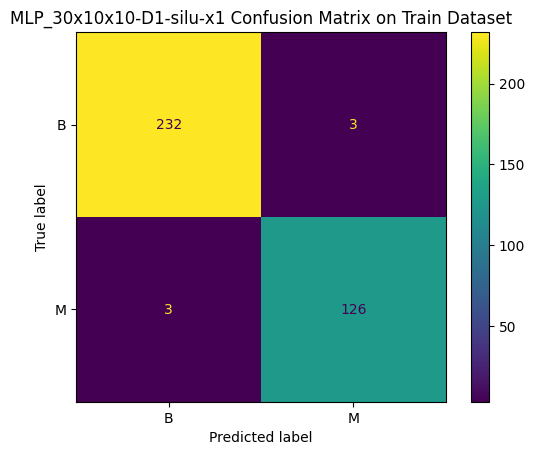

              precision    recall  f1-score   support

           B       0.99      0.99      0.99       235
           M       0.98      0.98      0.98       129

    accuracy                           0.98       364
   macro avg       0.98      0.98      0.98       364
weighted avg       0.98      0.98      0.98       364

Model Summary:


Model: "MLP_30x10x10-D1-silu-x1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.70 KB)

 Trainable params: 431 (1.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [50]:
for model_name, model in BEST_MODELS.items():
    model_result(model, X_train, y_train, 'Train')

#### Valid Evaluation on Best Models

Evaluation Report for Model: SLP on Valid
Loss Value: 0.077, Accuracy: 95.604%


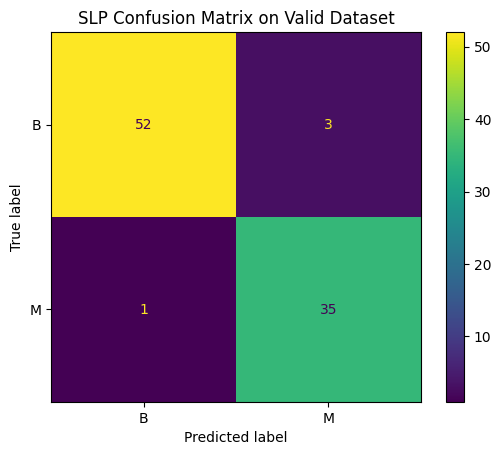

              precision    recall  f1-score   support

           B       0.98      0.95      0.96        55
           M       0.92      0.97      0.95        36

    accuracy                           0.96        91
   macro avg       0.95      0.96      0.95        91
weighted avg       0.96      0.96      0.96        91

Model Summary:


Model: "SLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64 (260.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33 (136.00 B)

None
Evaluation Report for Model: MLP_30x30x1 on Valid
Loss Value: 0.066, Accuracy: 97.802%


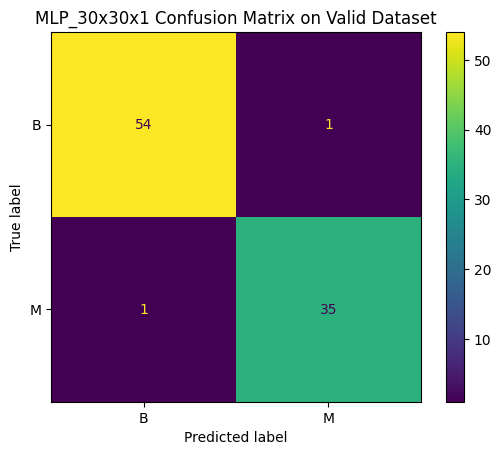

              precision    recall  f1-score   support

           B       0.98      0.98      0.98        55
           M       0.97      0.97      0.97        36

    accuracy                           0.98        91
   macro avg       0.98      0.98      0.98        91
weighted avg       0.98      0.98      0.98        91

Model Summary:


Model: "MLP_30x30x1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963 (3.77 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Evaluation Report for Model: MLP_30x10x10-D1-silu-x1 on Valid
Loss Value: 0.061, Accuracy: 98.901%


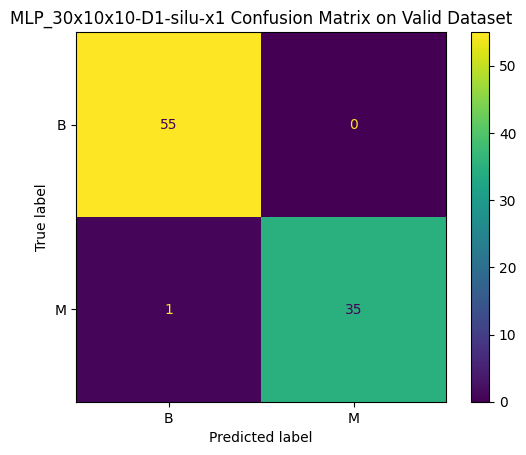

              precision    recall  f1-score   support

           B       0.98      1.00      0.99        55
           M       1.00      0.97      0.99        36

    accuracy                           0.99        91
   macro avg       0.99      0.99      0.99        91
weighted avg       0.99      0.99      0.99        91

Model Summary:


Model: "MLP_30x10x10-D1-silu-x1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.70 KB)

 Trainable params: 431 (1.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [103]:
for model_name, model in BEST_MODELS.items():
    model_result(model, X_val, y_val, 'Valid')

#### F1_Score, Precision, Recall and ROC on Validation Dataset of Best Models

In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score

nn_best_models_scores_df = pd.DataFrame(columns=['Model Name', 'Validation F1_Score', 'Validation Precision', 'Validation Recall'])

for model_name, model in BEST_MODELS.items():

    y_prob = model.predict(X_val, verbose=0)
    y_pred = np.round(y_prob).astype(int)    

    f1_score_res = f1_score(y_val, y_pred, labels=le.classes_)
    precision_score_res = precision_score(y_val, y_pred, labels=le.classes_)
    recall_score_res = recall_score(y_val, y_pred, labels=le.classes_)

    new_row = {'Model Name': model.name, 'Validation F1_Score': f1_score_res, 'Validation Precision': precision_score_res, 'Validation Recall': recall_score_res}
    nn_best_models_scores_df.loc[len(nn_best_models_scores_df)] = new_row

In [26]:
nn_best_models_scores_df

,Model Name,Validation F1_Score,Validation Precision,Validation Recall
0,SLP,0.945946,0.921053,0.972222
1,MLP_30x30x1,0.972222,0.972222,0.972222
2,MLP_30x10x10-D1-silu-x1,0.985915,1.000000,0.972222


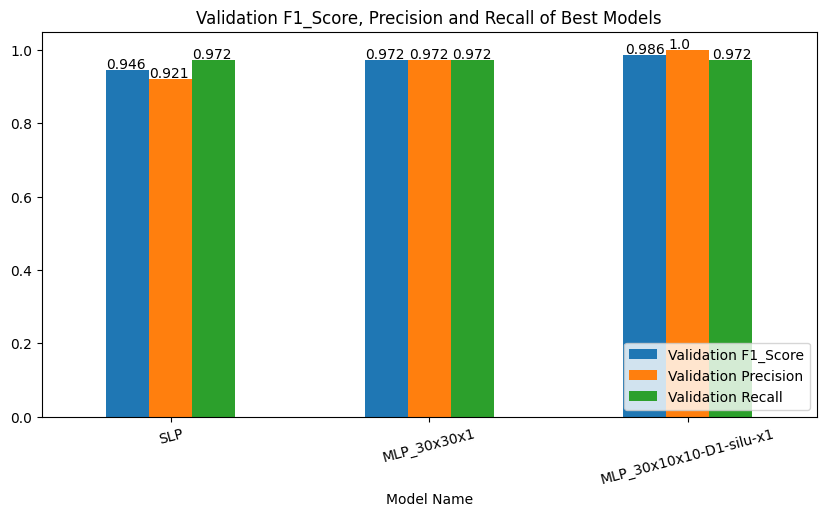

In [27]:
axes = nn_best_models_scores_df.plot.bar(x='Model Name', y=['Validation F1_Score', 'Validation Precision', 'Validation Recall'], rot=15, figsize=(10, 5))
axes.legend(loc='lower right')

for p in axes.patches:
    axes.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

_ = axes.set_title('Validation F1_Score, Precision and Recall of Best Models')

Model Name = SLP
FPR: [0.         0.         0.         0.05454545 0.05454545 1.        ]
TPR: [0.         0.25       0.97222222 0.97222222 1.         1.        ]
Thresholds: [          inf 1.0000000e+00 8.3580697e-01 6.7636168e-01 2.8125569e-01
 2.6973746e-06]
Positions of the false prediction in the validation dataset: [56]
Probability of the false prediciton: [[0.2812557]]
Model Name = MLP_30x30x1
FPR: [0.         0.         0.         0.07272727 0.07272727 1.        ]
TPR: [0.         0.11111111 0.97222222 0.97222222 1.         1.        ]
Thresholds: [          inf 1.0000000e+00 7.7876025e-01 3.4256026e-01 3.0257487e-01
 1.3059421e-04]
Positions of the false prediction in the validation dataset: [56]
Probability of the false prediciton: [[0.30257487]]
Model Name = MLP_30x10x10-D1-silu-x1
FPR: [0.         0.         0.         0.         0.12727273 0.12727273
 1.        ]
TPR: [0.         0.05555556 0.11111111 0.97222222 0.97222222 1.
 1.        ]
Thresholds: [          inf 1.00000

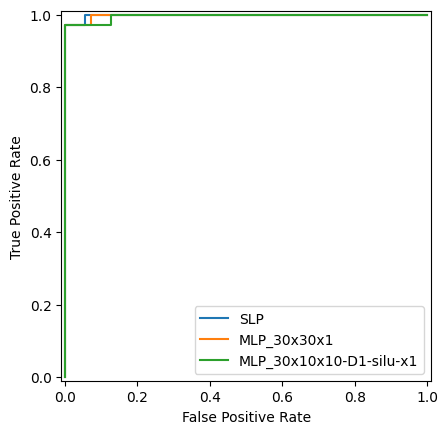

In [105]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

axes = plt.axes()
for model_name, model in BEST_MODELS.items():
    y_prob = model.predict(X_val, verbose=0)    
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_prob)
    print(f"Model Name = {model_name}")
    print(f'FPR: {fpr}')
    print(f'TPR: {tpr}')
    print(f'Thresholds: {thresholds}')
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=model.name)

    roc_disp.plot(ax=axes) 

    y_pred = np.round(y_prob).astype(int)    
    pos10 = (y_val==1) & (y_pred==0).flatten()
    X_failure_10 = X_val[pos10][:2]
    print(f'Positions of the false prediction in the validation dataset: {np.where(pos10)[0]}')
    print(f'Probability of the false prediciton: {y_prob[pos10]}')    

plt.show()

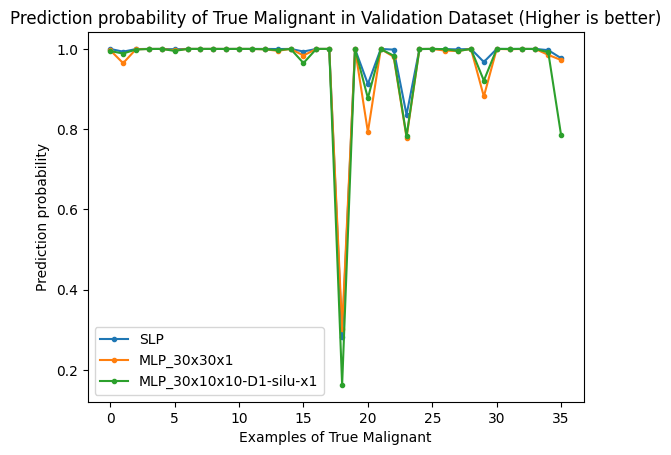

In [29]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

axes = plt.axes()
for model_name, model in BEST_MODELS.items():
    y_prob = model.predict(X_val, verbose=0)    
    pos1 = (y_val==1)

    plt.plot(y_prob[pos1], '.-', label=model.name)   

plt.title('Prediction probability of True Malignant in Validation Dataset (Higher is better)')
plt.ylabel('Prediction probability')
plt.xlabel('Examples of True Malignant')
plt.legend()
plt.show()

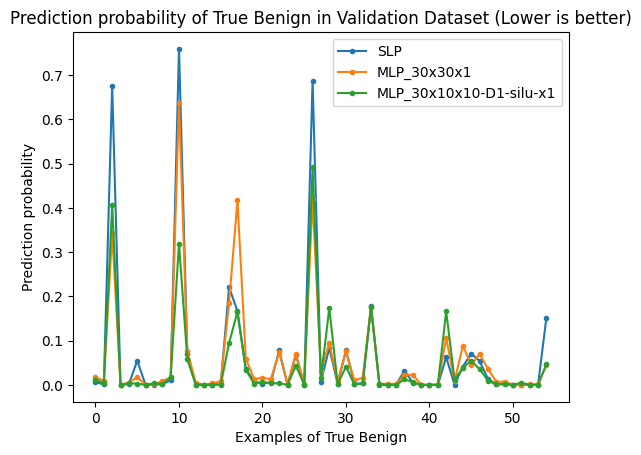

In [30]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

axes = plt.axes()
for model_name, model in BEST_MODELS.items():
    y_prob = model.predict(X_val, verbose=0)    
    pos0 = (y_val==0)

    plt.plot(y_prob[pos0], '.-', label=model.name)   

plt.title('Prediction probability of True Benign in Validation Dataset (Lower is better)')
plt.ylabel('Prediction probability')
plt.xlabel('Examples of True Benign')
plt.legend()
plt.show()

### Test Evaluation

In [147]:
nn_test_best_models_df = nn_best_models_df.drop(columns=['Train Accuracy', 'Train Loss'])
nn_test_best_models_df

,Model Name,Validation Accuracy,Validation Loss,Validation Recall
0,SLP,0.956044,0.076515,0.972222
1,MLP_30x30x1,0.978022,0.066211,0.972222
2,MLP_30x10x10-D1-silu-x1,0.989011,0.060973,0.972222


In [150]:

res_df = pd.DataFrame(columns=['Test Accuracy', 'Test Loss', 'Test Recall'])


for model_name, model in BEST_MODELS.items():
    res_dict = model.evaluate(X_test, y_test, verbose=0, return_dict=True)
    res_df.loc[len(res_df)] = {'Test Accuracy': res_dict['accuracy'], 'Test Loss': res_dict['loss'], 'Test Recall': res_dict['recall']}    

nn_test_best_models_df = pd.concat([nn_test_best_models_df, res_df], axis=1, join='inner')    
nn_test_best_models_df

,Model Name,Validation Accuracy,Validation Loss,Validation Recall,Test Accuracy,Test Loss,Test Recall
0,SLP,0.956044,0.076515,0.972222,0.938596,0.134041,0.978723
1,MLP_30x30x1,0.978022,0.066211,0.972222,0.938596,0.144221,0.957447
2,MLP_30x10x10-D1-silu-x1,0.989011,0.060973,0.972222,0.938596,0.098741,0.957447


##### Validation and Test Accuracy of all Best Models

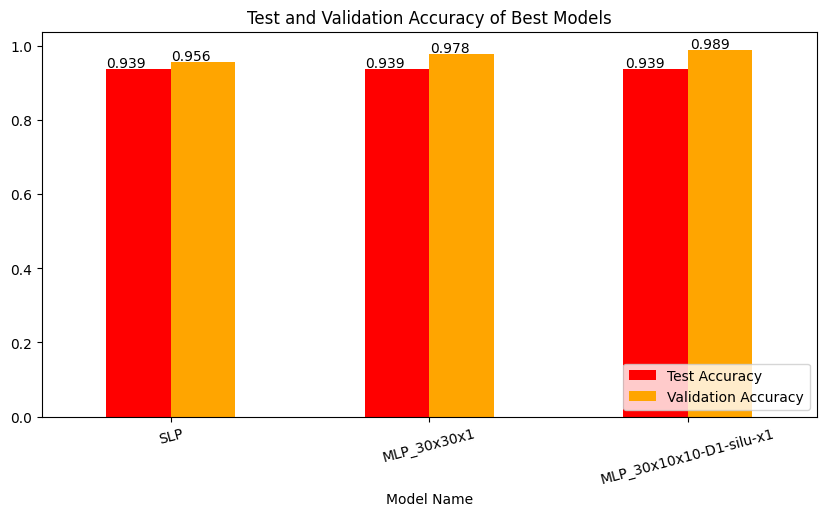

In [153]:
axes = nn_test_best_models_df.plot.bar(x='Model Name', y=['Test Accuracy', 'Validation Accuracy'], rot=15, figsize=(10, 5), color=['r', 'orange'])
axes.legend(loc='lower right')

for p in axes.patches:
    axes.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

_ = axes.set_title('Test and Validation Accuracy of Best Models')

##### Train and Validation Loss of all Best Models

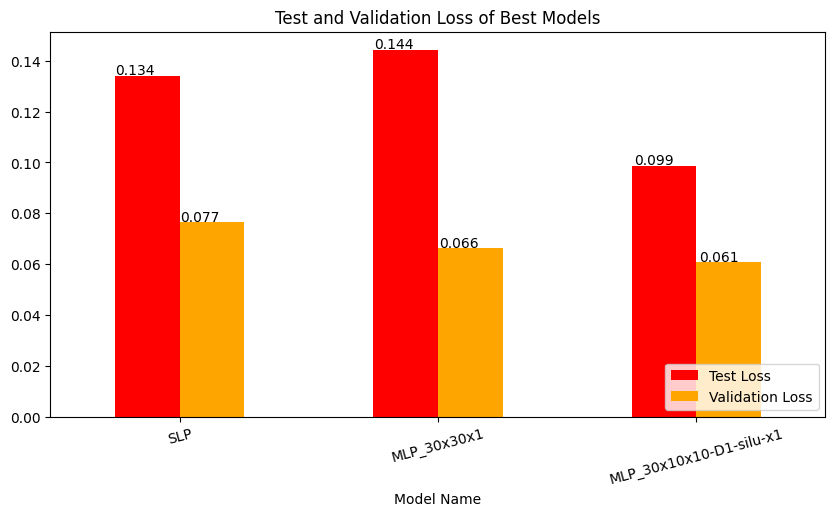

In [154]:
axes = nn_test_best_models_df.plot.bar(x='Model Name', y=['Test Loss', 'Validation Loss'], rot=15, figsize=(10, 5), color=['r', 'orange'])
axes.legend(loc='lower right')

for p in axes.patches:
    axes.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

_ = axes.set_title('Test and Validation Loss of Best Models')

#### Test Evaluation on Best Models

Evaluation Report for Model: SLP on Test
Loss Value: 0.134, Accuracy: 93.860%


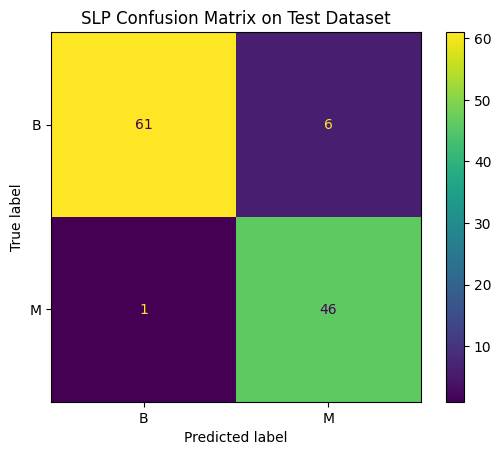

              precision    recall  f1-score   support

           B       0.98      0.91      0.95        67
           M       0.88      0.98      0.93        47

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.94       114
weighted avg       0.94      0.94      0.94       114

Model Summary:


Model: "SLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64 (260.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33 (136.00 B)

None
Evaluation Report for Model: MLP_30x30x1 on Test
Loss Value: 0.144, Accuracy: 93.860%


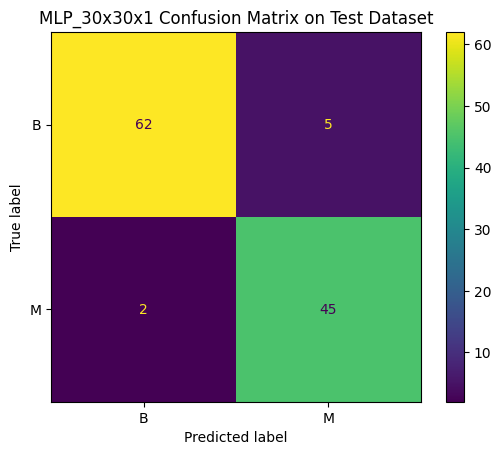

              precision    recall  f1-score   support

           B       0.97      0.93      0.95        67
           M       0.90      0.96      0.93        47

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.94       114
weighted avg       0.94      0.94      0.94       114

Model Summary:


Model: "MLP_30x30x1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963 (3.77 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
Evaluation Report for Model: MLP_30x10x10-D1-silu-x1 on Test
Loss Value: 0.099, Accuracy: 93.860%


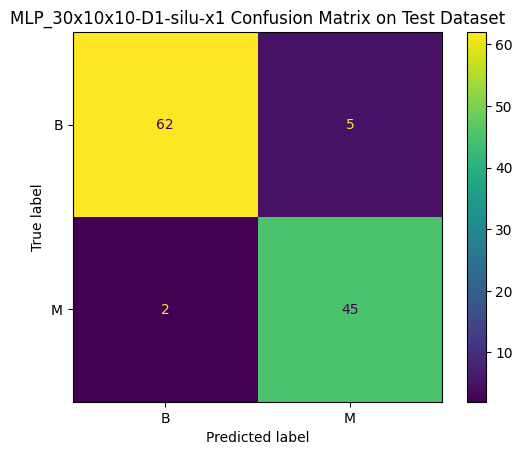

              precision    recall  f1-score   support

           B       0.97      0.93      0.95        67
           M       0.90      0.96      0.93        47

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.94       114
weighted avg       0.94      0.94      0.94       114

Model Summary:


Model: "MLP_30x10x10-D1-silu-x1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.70 KB)

 Trainable params: 431 (1.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [106]:
for model_name, model in BEST_MODELS.items():
    model_result(model, X_test, y_test, 'Test')

#### F1_Score, Precision, Recall and ROC on Test Dataset of Best Models

In [107]:
from sklearn.metrics import f1_score, precision_score, recall_score

nn_best_models_scores_df = pd.DataFrame(columns=['Model Name', 'Test F1_Score', 'Test Precision', 'Test Recall'])

for model_name, model in BEST_MODELS.items():

    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.round(y_prob).astype(int)    

    f1_score_res = f1_score(y_test, y_pred, labels=le.classes_)
    precision_score_res = precision_score(y_test, y_pred, labels=le.classes_)
    recall_score_res = recall_score(y_test, y_pred, labels=le.classes_)

    new_row = {'Model Name': model.name, 'Test F1_Score': f1_score_res, 'Test Precision': precision_score_res, 'Test Recall': recall_score_res}
    nn_best_models_scores_df.loc[len(nn_best_models_scores_df)] = new_row

In [108]:
nn_best_models_scores_df

,Model Name,Test F1_Score,Test Precision,Test Recall
0,SLP,0.929293,0.884615,0.978723
1,MLP_30x30x1,0.927835,0.900000,0.957447
2,MLP_30x10x10-D1-silu-x1,0.927835,0.900000,0.957447


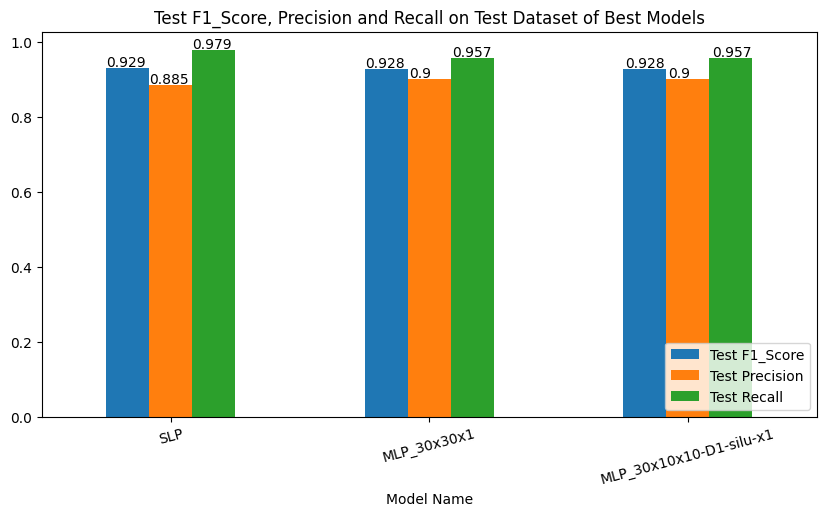

In [113]:
axes = nn_best_models_scores_df.plot.bar(x='Model Name', y=['Test F1_Score', 'Test Precision', 'Test Recall'], rot=15, figsize=(10, 5))
axes.legend(loc='lower right')

for p in axes.patches:
    axes.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

_ = axes.set_title('Test F1_Score, Precision and Recall on Test Dataset of Best Models')

FPR: [0.         0.         0.         0.         0.         0.04477612
 0.04477612 0.05970149 0.05970149 0.37313433 0.37313433 1.        ]
TPR: [0.         0.14893617 0.31914894 0.36170213 0.93617021 0.93617021
 0.95744681 0.95744681 0.9787234  0.9787234  1.         1.        ]
Thresholds: [          inf 1.0000000e+00 9.9999875e-01 9.9999750e-01 8.9176440e-01
 6.7558831e-01 6.5725094e-01 5.8702481e-01 5.3255576e-01 1.4948736e-02
 1.3808657e-02 1.1280548e-08]
Positions of the false prediction in the test dataset: [109]
Probability of the false prediciton: [[0.01380866]]
FPR: [0.         0.         0.         0.         0.02985075 0.02985075
 0.11940299 0.11940299 0.43283582 0.43283582 1.        ]
TPR: [0.         0.04255319 0.08510638 0.91489362 0.91489362 0.95744681
 0.95744681 0.9787234  0.9787234  1.         1.        ]
Thresholds: [          inf 1.0000000e+00 9.9999988e-01 9.2842036e-01 7.5213116e-01
 7.3566246e-01 3.0896330e-01 2.8792349e-01 2.0365650e-02 2.0068256e-02
 1.1823071e

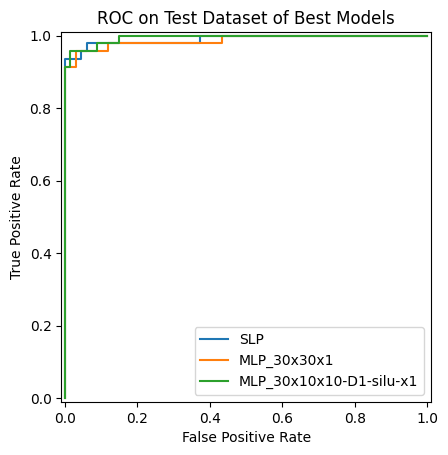

In [114]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

axes = plt.axes()
for model_name, model in BEST_MODELS.items():
    y_prob = model.predict(X_test, verbose=0)    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)

    print(f'FPR: {fpr}')
    print(f'TPR: {tpr}')
    print(f'Thresholds: {thresholds}')
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=model.name)

    roc_disp.plot(ax=axes) 

    y_pred = np.round(y_prob).astype(int)    
    pos10 = (y_test==1) & (y_pred==0).flatten()
    X_failure_10 = X_test[pos10][:2]
    print(f'Positions of the false prediction in the test dataset: {np.where(pos10)[0]}')
    print(f'Probability of the false prediciton: {y_prob[pos10]}')    

plt.title('ROC on Test Dataset of Best Models')
plt.show()

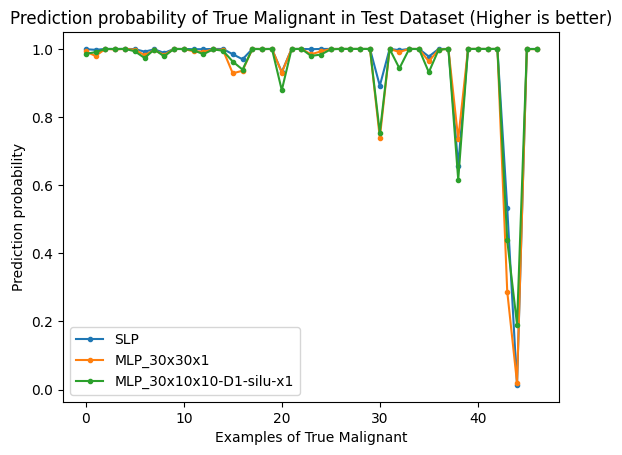

In [111]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

axes = plt.axes()
for model_name, model in BEST_MODELS.items():
    y_prob = model.predict(X_test, verbose=0)    
    pos1 = (y_test==1)

    plt.plot(y_prob[pos1], '.-', label=model.name)   

plt.title('Prediction probability of True Malignant in Test Dataset (Higher is better)')
plt.ylabel('Prediction probability')
plt.xlabel('Examples of True Malignant')
plt.legend()
plt.show()

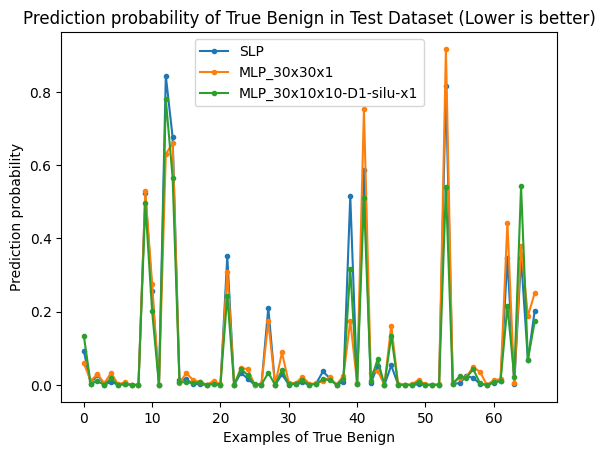

In [112]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

axes = plt.axes()
for model_name, model in BEST_MODELS.items():
    y_prob = model.predict(X_test, verbose=0)    
    pos0 = (y_test==0)

    plt.plot(y_prob[pos0], '.-', label=model.name)   

plt.title('Prediction probability of True Benign in Test Dataset (Lower is better)')
plt.ylabel('Prediction probability')
plt.xlabel('Examples of True Benign')
plt.legend()
plt.show()

### Cases of Success and Failure

In [258]:
model = BEST_MODELS['SLP']

y_prob = model.predict(X_test, verbose=0)
y_pred = np.round(y_prob).astype(int) 
y_pred = y_pred.flatten() 

#### Best Model Success

Truth Benign, Predicted Bengin

In [157]:
pos00 = (y_test==0) & (y_pred==0).flatten()
X_success_00 = X_test[pos00][[0]]
pd.DataFrame(X_success_00)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.006588,1.196721,-0.042276,0.001842,-0.461978,-0.658807,-0.37186,-0.261477,-0.533846,-0.721786,...,-0.066365,1.091076,-0.129989,-0.047531,-0.141608,-0.550007,-0.337315,-0.417063,-0.555473,-0.579945


Truth Malignant, Predicted Malignant

In [70]:
pos11 = (y_test==1) & (y_pred==1).flatten()
X_success_11 = X_test[pos11][:2]
pd.DataFrame(X_success_11)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.056653,0.335155,0.124621,0.059559,0.715806,0.862505,0.970516,1.031401,0.995385,1.467463,...,0.347914,0.530512,0.452710,0.401252,0.854895,0.906768,1.094394,1.152402,1.143708,1.566226
1,0.599473,-1.236794,0.634133,0.612787,1.499611,1.000441,1.645267,1.624040,0.533846,1.145552,...,0.826546,-1.017479,0.762459,0.947854,0.704545,0.764376,1.373338,0.910030,0.594192,1.072337


#### Best Model Failure

Truth Benign, Predicted Malignant

In [499]:
(y_test==0) & (y_pred==1)

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [492]:
pos01 = (y_test==0) & (y_pred==1).flatten()
X_failure_01 = X_test[pos01][:]
pd.DataFrame(X_failure_01)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.396574,-0.856102,0.476794,0.364725,0.326499,1.451141,0.976263,0.634895,0.903077,1.569318,...,0.357969,-0.858019,0.473890,0.326561,-0.061189,0.791498,0.367367,0.132060,0.014892,0.627338
1,0.963109,0.142077,0.851025,1.052729,-1.160654,-0.335138,-0.098511,-0.112576,0.158462,-1.119145,...,0.711916,0.335480,0.638030,0.799321,-1.580769,-0.212544,-0.147756,-0.154025,-0.431869,-0.987029
2,0.383399,-0.626594,0.386729,0.351831,0.850766,0.653996,0.455084,0.796717,0.995385,0.236404,...,0.333836,-0.870285,0.349461,0.314678,-0.183566,0.506715,0.130418,0.444763,0.497394,0.260664
3,-0.301713,1.723133,-0.308795,-0.268325,-0.482222,-0.531296,-0.418415,-0.196029,0.189231,-0.578434,...,-0.217195,0.980681,-0.237210,-0.186091,-1.008741,-0.597157,-0.660027,-0.466620,-0.615041,-0.654278
4,0.325428,-0.389800,0.327176,0.318981,0.036335,0.333213,0.229898,0.194970,0.367692,0.319396,...,0.400201,-0.469181,0.402409,0.438810,-0.124126,0.653801,0.573878,0.463157,0.351452,0.405837
5,0.475626,0.624772,0.451429,0.480160,-0.605243,0.150367,0.097937,0.121472,0.466154,-0.308079,...,0.418301,0.762343,0.370640,0.449419,-0.882867,0.640240,0.326912,0.348464,0.515264,0.648790


Truth Malignant, Predicted Benign

In [494]:
pos10 = (y_test==1) & (y_pred==0).flatten()
X_failure_10 = X_test[pos10][:2]
pd.DataFrame(X_failure_10)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.115942,1.253188,1.075269,1.26088,0.19673,0.34444,1.242945,0.697802,-1.490769,-0.36718,...,0.68175,0.33548,0.640678,0.77598,-0.302448,-0.169253,0.207089,0.122322,-1.807893,-0.564979


#### More Successful Classifications

##### Example 1 - (TN) - Benign classified as Benign

In [500]:
example_num = np.array([1])

data_B_mean = X[y==0].mean()
data_B_std = X[y==0].std()

wrong_classified_data = scaler.inverse_transform(X_test)[example_num].T.flatten()
wrong_classified_data = pd.Series(wrong_classified_data, index=data_B_mean.index)

wrong_classified_data_n_2 = (wrong_classified_data-data_B_mean)/data_B_std

res_df = pd.concat([wrong_classified_data, data_B_mean, data_B_std, wrong_classified_data_n_2], axis=1)
res_df = res_df.rename(columns={0: 'Example', 1: 'Feature Mean', 2: 'Feature STD', 3: 'Normalized Example'})
res_df.style.apply(lambda x: ["background: green" if idx==3 and abs(v)>abs(3*x.iloc[2]) else "" for idx,v in enumerate(x)], axis = 1)

,Example,Feature Mean,Feature STD,Normalized Example
radius_mean,13.210000,12.146524,1.780512,0.597287
texture_mean,25.250000,17.914762,3.995125,1.836047
perimeter_mean,84.100000,78.075406,11.807438,0.510237
area_mean,537.900000,462.790196,134.287118,0.559322
smoothness_mean,0.087910,0.092478,0.013446,-0.339701
compactness_mean,0.052050,0.080085,0.033750,-0.830657
concavity_mean,0.027720,0.046058,0.043442,-0.422116
concave points_mean,0.020680,0.025717,0.015909,-0.316643
symmetry_mean,0.161900,0.174186,0.024807,-0.495268
fractal_dimension_mean,0.055840,0.062867,0.006747,-1.041506


##### Example 106 - (TP) - Malignant classified as Malignant on all the Best Classifiers

In [501]:
example_num = np.array([106])

data_M_mean = X[y==1].mean()
data_M_std = X[y==1].std()

wrong_classified_data = scaler.inverse_transform(X_test)[example_num].T.flatten()
wrong_classified_data = pd.Series(wrong_classified_data, index=data_M_mean.index)

wrong_classified_data_n_2 = (wrong_classified_data-data_M_mean)/data_M_std

res_df = pd.concat([wrong_classified_data, data_M_mean, data_M_std, wrong_classified_data_n_2], axis=1)
res_df = res_df.rename(columns={0: 'Example', 1: 'Feature Mean', 2: 'Feature STD', 3: 'Normalized Example'})
res_df.style.apply(lambda x: ["background: green" if idx==3 and abs(v)>abs(3*x.iloc[2]) else "" for idx,v in enumerate(x)], axis = 1)

,Example,Feature Mean,Feature STD,Normalized Example
radius_mean,17.910000,17.462830,3.203971,0.139567
texture_mean,21.020000,21.604906,3.779470,-0.154759
perimeter_mean,124.400000,115.365377,21.854653,0.413396
area_mean,994.000000,978.376415,367.937978,0.042463
smoothness_mean,0.123000,0.102898,0.012608,1.594316
compactness_mean,0.257600,0.145188,0.053987,2.082190
concavity_mean,0.318900,0.160775,0.075019,2.107794
concave points_mean,0.119800,0.087990,0.034374,0.925411
symmetry_mean,0.211300,0.192909,0.027638,0.665424
fractal_dimension_mean,0.071150,0.062680,0.007573,1.118388


##### Example 112 - (TP) - Malignant classified as Malignant on all the Best Classifiers

In [502]:
example_num = np.array([112])

data_M_mean = X[y==1].mean()
data_M_std = X[y==1].std()

wrong_classified_data = scaler.inverse_transform(X_test)[example_num].T.flatten()
wrong_classified_data = pd.Series(wrong_classified_data, index=data_M_mean.index)

wrong_classified_data_n_2 = (wrong_classified_data-data_M_mean)/data_M_std

res_df = pd.concat([wrong_classified_data, data_M_mean, data_M_std, wrong_classified_data_n_2], axis=1)
res_df = res_df.rename(columns={0: 'Example', 1: 'Feature Mean', 2: 'Feature STD', 3: 'Normalized Example'})
res_df.style.apply(lambda x: ["background: green" if idx==3 and abs(v)>abs(3*x.iloc[2]) else "" for idx,v in enumerate(x)], axis = 1)

,Example,Feature Mean,Feature STD,Normalized Example
radius_mean,18.310000,17.462830,3.203971,0.264412
texture_mean,20.580000,21.604906,3.779470,-0.271177
perimeter_mean,120.800000,115.365377,21.854653,0.248671
area_mean,1052.000000,978.376415,367.937978,0.200098
smoothness_mean,0.106800,0.102898,0.012608,0.309441
compactness_mean,0.124800,0.145188,0.053987,-0.377639
concavity_mean,0.156900,0.160775,0.075019,-0.051650
concave points_mean,0.094510,0.087990,0.034374,0.189679
symmetry_mean,0.186000,0.192909,0.027638,-0.249980
fractal_dimension_mean,0.059410,0.062680,0.007573,-0.431792


#### More Failure Classifications

##### Example 108 - (FN) - Malignant classified as Benign on most of the Best Classifiers

In [503]:
example_num = np.array([108])

data_M_mean = X[y==1].mean()
data_M_std = X[y==1].std()

wrong_classified_data = scaler.inverse_transform(X_test)[example_num].T.flatten()
wrong_classified_data = pd.Series(wrong_classified_data, index=data_M_mean.index)

wrong_classified_data_n_2 = (wrong_classified_data-data_M_mean)/data_M_std

res_df = pd.concat([wrong_classified_data, data_M_mean, data_M_std, wrong_classified_data_n_2], axis=1)
res_df = res_df.rename(columns={0: 'Example', 1: 'Feature Mean', 2: 'Feature STD', 3: 'Normalized Example'})
res_df.style.apply(lambda x: ["background: green" if idx==3 and abs(v)>abs(3*x.iloc[2]) else "" for idx,v in enumerate(x)], axis = 1)

,Example,Feature Mean,Feature STD,Normalized Example
radius_mean,15.610000,17.462830,3.203971,-0.578292
texture_mean,19.380000,21.604906,3.779470,-0.588682
perimeter_mean,100.000000,115.365377,21.854653,-0.703071
area_mean,758.600000,978.376415,367.937978,-0.597319
smoothness_mean,0.078400,0.102898,0.012608,-1.943055
compactness_mean,0.056160,0.145188,0.053987,-1.649045
concavity_mean,0.042090,0.160775,0.075019,-1.582055
concave points_mean,0.028470,0.087990,0.034374,-1.731546
symmetry_mean,0.154700,0.192909,0.027638,-1.382475
fractal_dimension_mean,0.054430,0.062680,0.007573,-1.089364


##### Example 109 - (FN) - Malignant classified as Benign on all the Best Classifiers

In [504]:
example_num = np.array([109])

data_M_mean = X[y==1].mean()
data_M_std = X[y==1].std()

wrong_classified_data = scaler.inverse_transform(X_test)[example_num].T.flatten()
wrong_classified_data = pd.Series(wrong_classified_data, index=data_M_mean.index)

wrong_classified_data_n_2 = (wrong_classified_data-data_M_mean)/data_M_std

res_df = pd.concat([wrong_classified_data, data_M_mean, data_M_std, wrong_classified_data_n_2], axis=1)
res_df = res_df.rename(columns={0: 'Example', 1: 'Feature Mean', 2: 'Feature STD', 3: 'Normalized Example'})
res_df.style.apply(lambda x: ["background: green" if idx==3 and abs(v)>abs(3*x.iloc[2]) else "" for idx,v in enumerate(x)], axis = 1)

,Example,Feature Mean,Feature STD,Normalized Example
radius_mean,17.420000,17.462830,3.203971,-0.013368
texture_mean,25.560000,21.604906,3.779470,1.046468
perimeter_mean,114.500000,115.365377,21.854653,-0.039597
area_mean,948.000000,978.376415,367.937978,-0.082559
smoothness_mean,0.100600,0.102898,0.012608,-0.182301
compactness_mean,0.114600,0.145188,0.053987,-0.566572
concavity_mean,0.168200,0.160775,0.075019,0.098978
concave points_mean,0.065970,0.087990,0.034374,-0.640602
symmetry_mean,0.130800,0.192909,0.027638,-2.247223
fractal_dimension_mean,0.058660,0.062680,0.007573,-0.530824


##### Example 13 - (FP) - Benign classified as Malignant

In [505]:
example_num = np.array([13])

data_B_mean = X[y==0].mean()
data_B_std = X[y==0].std()

wrong_classified_data = scaler.inverse_transform(X_test)[example_num].T.flatten()
wrong_classified_data = pd.Series(wrong_classified_data, index=data_B_mean.index)

wrong_classified_data_n_2 = (wrong_classified_data-data_B_mean)/data_B_std

res_df = pd.concat([wrong_classified_data, data_B_mean, data_B_std, wrong_classified_data_n_2], axis=1)
res_df = res_df.rename(columns={0: 'Example', 1: 'Feature Mean', 2: 'Feature STD', 3: 'Normalized Example'})
res_df.style.apply(lambda x: ["background: green" if idx==3 and abs(v)>abs(3*x.iloc[2]) else "" for idx,v in enumerate(x)], axis = 1)

,Example,Feature Mean,Feature STD,Normalized Example
radius_mean,16.840000,12.146524,1.780512,2.636027
texture_mean,19.460000,17.914762,3.995125,0.386781
perimeter_mean,108.400000,78.075406,11.807438,2.568262
area_mean,880.200000,462.790196,134.287118,3.108338
smoothness_mean,0.074450,0.092478,0.013446,-1.340737
compactness_mean,0.072230,0.080085,0.033750,-0.232730
concavity_mean,0.051500,0.046058,0.043442,0.125279
concave points_mean,0.027710,0.025717,0.015909,0.125251
symmetry_mean,0.184400,0.174186,0.024807,0.411743
fractal_dimension_mean,0.052680,0.062867,0.006747,-1.509838


### Notebook End

In [ ]:
notebook_end = time.time()
notebook_elapsed = notebook_end-notebook_start
print('Finished Notebook Run!')
print(f'Elapsed Run Time: {math.floor(notebook_elapsed/3600)} (h), {math.floor(notebook_elapsed%3600/60)} (m), {math.floor(notebook_elapsed%60)} (s)')

Finished Notebook Run!
Elapsed Run Time: 0 (h), 26 (m), 51 (s)
